First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per feature
* A target key containing an array with the labels

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function:

In [7]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

Saving figure some_digit_plot


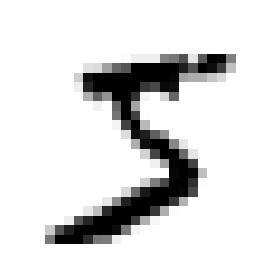

In [47]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
save_fig("some_digit_plot")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [9]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

In [9]:
y = y.astype(np.uint8)

In [10]:
y[0]

5

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


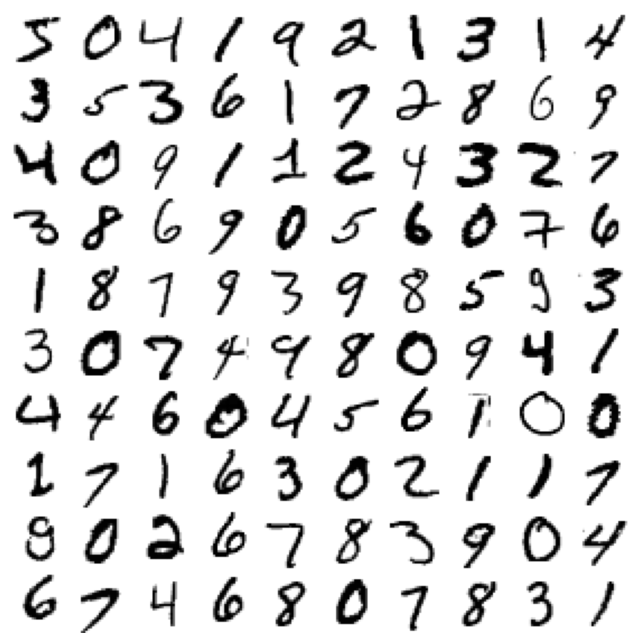

In [48]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). `Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.` Shuffling the dataset ensures that this won’t happen.

### Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [12]:
y_train_5 = (y_train == 5) # True for all 5s, and False otherwise
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a `Stochastic Gradient Descent (SGD) classifier`, using Scikit-Learn’s `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently. `This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)`, as we will see later. Let’s create an SGDClassifier and train it on the whole training se

In [14]:
from sklearn.linear_model import SGDClassifier

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

## TIP

The `SGDClassifier` relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the `random_state` parameter.

Now we can use it to detect images of Number 5.

In [16]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let's evaluate this model's performance.

### Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available, so grab another coffee and get ready to learn many new concepts and acronyms!

### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation, just as you did in Chapter 2.

## Implementing CROSS-VALIDATION

> Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation yourself. The following code does roughly the same thing as Scikit-Learn’s `cross_val_score()` function, and it prints the same result:

In [15]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.base import clone

In [20]:
StratifiedShuffleSplit??

Init signature:
StratifiedShuffleSplit(
    n_splits=10,
    *,
    test_size=None,
    train_size=None,
    random_state=None,
)
Source:        
class StratifiedShuffleSplit(BaseShuffleSplit):
    """Stratified ShuffleSplit cross-validator

    Provides train/test indices to split data in train/test sets.

    This cross-validation object is a merge of StratifiedKFold and
    ShuffleSplit, which returns stratified randomized folds. The folds
    are made by preserving the percentage of samples for each class.

    Note: like the ShuffleSplit strategy, stratified random splits
    do not guarantee that all folds will be different, although this is
    still very likely for sizeable datasets.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    n_splits : int, default=10
        Number of re-shuffling & splitting iterations.

    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
 

In [29]:
StratifiedKFold??

Init signature: StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)
Source:        
class StratifiedKFold(_BaseKFold):
    """Stratified K-Folds cross-validator

    Provides train/test indices to split data in train/test sets.

    This cross-validation object is a variation of KFold that returns
    stratified folds. The folds are made by preserving the percentage of
    samples for each class.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.

        .. versionchanged:: 0.22
            ``n_splits`` default value changed from 3 to 5.

    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.

    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
      

In [23]:
clone??

Signature: clone(estimator, *, safe=True)
Source:   
@_deprecate_positional_args
def clone(estimator, *, safe=True):
    """Constructs a new estimator with the same parameters.

    Clone does a deep copy of the model in an estimator
    without actually copying attached data. It yields a new estimator
    with the same parameters that has not been fit on any data.

    Parameters
    ----------
    estimator : {list, tuple, set} of estimator objects or estimator object
        The estimator or group of estimators to be cloned.

    safe : bool, default=True
        If safe is false, clone will fall back to a deep copy on objects
        that are not estimators.

    """
    estimator_type = type(estimator)
    # XXX: not handling dictionaries
    if estimator_type in (list, tuple, set, frozenset):
        return estimator_type([clone(e, safe=safe) for e in estimator])
    elif not hasattr(estimator, 'get_params') or isinstance(estimator, type):
        if not safe:
            return 

In [28]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_test_fold))
    

/home/owl/Documents/venv/tlfMaths3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


> The StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let’s use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds (see Chapter 2):

In [16]:
from sklearn.model_selection import cross_val_score

In [22]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a `very dumb classifier` that just classifies every single image in the “not-5” class:

In [17]:
from sklearn.base import BaseEstimator

In [25]:
BaseEstimator??

Init signature: BaseEstimator()
Source:        
class BaseEstimator:
    """Base class for all estimators in scikit-learn

    Notes
    -----
    All estimators should specify all the parameters that can be set
    at the class level in their ``__init__`` as explicit keyword
    arguments (no ``*args`` or ``**kwargs``).
    """

    @classmethod
    def _get_param_names(cls):
        """Get parameter names for the estimator"""
        # fetch the constructor or the original constructor before
        # deprecation wrapping if any
        init = getattr(cls.__init__, 'deprecated_original', cls.__init__)
        if init is object.__init__:
            # No explicit constructor to introspect
            return []

        # introspect the constructor arguments to find the model parameters
        # to represent
        init_signature = inspect.signature(init)
        # Consider the constructor parameters excluding 'self'
        parameters = [p for p in init_signature.parameters.values()

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Can you guess this model's accuracy? Let's find out:

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why `accuracy` is generally `not the preferred performance measure for classifiers`, especially when you are dealing with `skewed datasets` (i.e., when some classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. </br> 
For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the `cross_val_predict()` function:

In [13]:
from sklearn.model_selection import cross_val_predict

In [29]:
cross_val_predict??

Signature:
cross_val_predict(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    method='predict',
)
Source:   
@_deprecate_positional_args
def cross_val_predict(estimator, X, y=None, *, groups=None, cv=None,
                      n_jobs=None, verbose=0, fit_params=None,
                      pre_dispatch='2*n_jobs', method='predict'):
    """Generate cross-validated estimates for each input data point

    The data is split according to the cv parameter. Each sample belongs
    to exactly one test set, and its prediction is computed with an
    estimator fitted on the corresponding training set.

    Passing these predictions into an evaluation metric may not be a valid
    way to measure generalization performance. Results can differ from
    :func:`cross_validate` and :func:`cross_val_score` unless all tests sets
    have equal size and the metric decomposes over samples.

    R

In [21]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs `K-fold cross-validation`, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a `clean prediction` for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [24]:
y_train_pred[0]

True

In [32]:
type(y_train_pred), y_train_pred.shape

(numpy.ndarray, (60000,))

In [14]:
from sklearn.metrics import confusion_matrix

In [26]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* Each row in a confusion matrix represents an **actual class**, while each column represents a **predicted class**.
* The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called `true negatives`), while the remaining 687 were wrongly classified as 5s (`false positives`). 
* The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (`false negatives`), while the remaining 3,530 were correctly classified as 5s (`true positives`). 
* A `perfect classifier` would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [27]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the `precision of the classifier`** (Equation 3-1).

**Equation 3-1. `Precision`** </br>
$$precision = \frac{TP}{TP + FP}$$

*TP* is the number of *true positives*, and *FP* is the number of *false positives*.

**A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named `recall`, _also called sensitivity or the true positive rate (TPR)_: this is the ratio of positive instances that are correctly detected by the classifier** (Equation 3-2).

**Equation 3-2. `Recall`** </br>
$$recall = \frac{TP}{TP + FN}$$

FN is, of course, the number of false negatives.

If you are confused about the confusion matrix, below figure may help.

![Confusion Matrix Image](images/confusion_matrix.png)

## Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [15]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, precision_recall_fscore_support

In [38]:
recall_score??

Signature:
recall_score(
    y_true,
    y_pred,
    *,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
Source:   
@_deprecate_positional_args
def recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary',
                 sample_weight=None, zero_division="warn"):
    """Compute the recall

    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.

    The best value is 1 and the worst value is 0.

    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier

In [39]:
precision_score??

Signature:
precision_score(
    y_true,
    y_pred,
    *,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
Source:   
@_deprecate_positional_args
def precision_score(y_true, y_pred, *, labels=None, pos_label=1,
                    average='binary', sample_weight=None,
                    zero_division="warn"):
    """Compute the precision

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The best value is 1 and the worst value is 0.

    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse 

In [41]:
precision_recall_curve??

Signature:
precision_recall_curve(
    y_true,
    probas_pred,
    *,
    pos_label=None,
    sample_weight=None,
)
Source:   
@_deprecate_positional_args
def precision_recall_curve(y_true, probas_pred, *, pos_label=None,
                           sample_weight=None):
    """Compute precision-recall pairs for different probability thresholds

    Note: this implementation is restricted to the binary classification task.

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.

    The last precision and recall values are 1. and 0. respectively and do not


In [42]:
precision_recall_fscore_support??

Signature:
precision_recall_fscore_support(
    y_true,
    y_pred,
    *,
    beta=1.0,
    labels=None,
    pos_label=1,
    average=None,
    warn_for=('precision', 'recall', 'f-score'),
    sample_weight=None,
    zero_division='warn',
)
Source:   
@_deprecate_positional_args
def precision_recall_fscore_support(y_true, y_pred, *, beta=1.0, labels=None,
                                    pos_label=1, average=None,
                                    warn_for=('precision', 'recall',
                                              'f-score'),
                                    sample_weight=None,
                                    zero_division="warn"):
    """Compute precision, recall, F-measure and support for each class

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

   

In [43]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [44]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [47]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [49]:
3530/(3530 + 687), 3530/(3530 + 1891) # Precision and recall score if I consider TRUE as correct classification of 5.

(0.8370879772350012, 0.6511713705958311)

In [50]:
53892/(53892 + 1891), 53892/(53892 + 687) # Precision and recall score if I consider TRUE as correct classification of non-5.

(0.9661007833927899, 0.987412741164184)

**Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.**

It is often convenient to **combine precision and recall** into a single metric called the **`F1 score`**, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

**Equation 3-3. $F_1$** </br>
$$F_1 = \frac{TP}{TP + \frac{FN + FP}{2}}$$

To compute the F1 score, simply call the `f1_score()` function:

In [16]:
from sklearn.metrics import f1_score

In [54]:
f1_score??

Signature:
f1_score(
    y_true,
    y_pred,
    *,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
Source:   
@_deprecate_positional_args
def f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary',
             sample_weight=None, zero_division="warn"):
    """Compute the F1 score, also known as balanced F-score or F-measure

    The F1 score can be interpreted as a weighted average of the precision and
    recall, where an F1 score reaches its best value at 1 and worst score at 0.
    The relative contribution of precision and recall to the F1 score are
    equal. The formula for the F1 score is::

        F1 = 2 * (precision * recall) / (precision + recall)

    In the multi-class and multi-label case, this is the average of
    the F1 score of each class with weighting depending on the ``average``
    parameter.

    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

    Parameters
  

In [55]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [59]:
type(y_train_5), y_train_5.shape

(numpy.ndarray, (60000,))

In [60]:
f1_score(y_train_5, y_train_perfect_predictions)

1.0

* The `F1 score` favors classifiers that have similar `precision and recall`. </br>
* `This is not always what you want`: in some contexts you mostly `care about precision`, and `in other contexts you really care about recall`. </br>
* `For example`, 
    * if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). 
    * On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).
    
`Unfortunately, you can’t have it both ways`: `increasing precision reduces recall, and vice versa`. This is called the `precision/recall trade-off`.

## Precision/Recall Trade-off

To understand this trade-off, let’s look at how the `SGDClassifier` makes its classification decisions. </br>
For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. <br>
Figure 3-3 shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases recall and reduces precision.

![Precision/Recall Trade-Off](images/precision_recall_trade_off.png)

> **Scikit-Learn does not let you set the threshold directly**, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [82]:
y_score = sgd_clf.decision_function([some_digit])

In [83]:
y_score

array([2164.22030239])

In [84]:
threshold = 0

In [85]:
y_some_digit_pred = y_score > threshold

In [86]:
y_some_digit_pred

array([ True])

The `SGDClassifier` uses a threshold equal to 0, so the previous code returns the same result as the `predict()` method (i.e., True). Let’s raise the threshold:

In [88]:
threshold = 8000
y_some_digit_pred = y_score > threshold
y_some_digit_pred

array([False])

**This confirms that raising the threshold decreases recall**. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000.

How do you decide which threshold to use? First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [84]:
y_scores[0]

1200.930512369027

In [81]:
y_scores.min(), y_scores.max(), y_scores.mean(), y_scores.std()

(-146348.56726173862,
 49441.437659047755,
 -18071.705387563583,
 14096.88570506998)

With these scores, use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

In [22]:
from sklearn.metrics import precision_recall_curve

In [32]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [33]:
type(precisions), type(recalls), type(thresholds)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [34]:
precisions.shape, recalls.shape, thresholds.shape

((59967,), (59967,), (59966,))

In [49]:
ind = 55500
precisions[ind], recalls[ind], thresholds[ind]

(0.8213166144200627, 0.6766279284264896, -530.5237933325346)

Finally, use `Matplotlib` to plot `precision` and `recall` as functions of the threshold value:

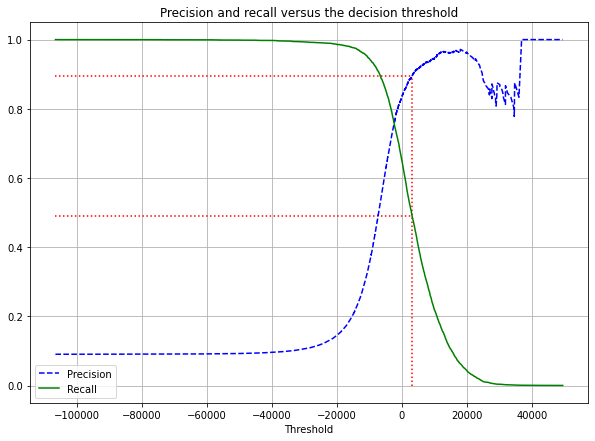

In [145]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 7))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend()
    plt.xlabel('Threshold')
    plt.title('Precision and recall versus the decision threshold')
    plt.vlines(thresholds[57000], min(precisions.min(), recalls.min()), precisions[57000], colors='r', linestyles='dotted')
    plt.hlines(precisions[57000], thresholds.min(), thresholds[57000], colors='r', linestyles='dotted')
    plt.hlines(recalls[57000], thresholds.min(), thresholds[57000], colors='r', linestyles='dotted')
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

## NOTE

> You may wonder why the `precision curve is bumpier than the recall curve` in above Figure. <br>
> The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). To understand why, look back at Figure 3-3 and notice what happens when you start from the central threshold and move it just one digit to the right: precision goes from 4/5 (80%) down to 3/4 (75%). On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

Another way to `select a good precision/recall trade-off` is to plot precision directly against recall, as shown in below Figure (the same threshold as earlier is highlighted).

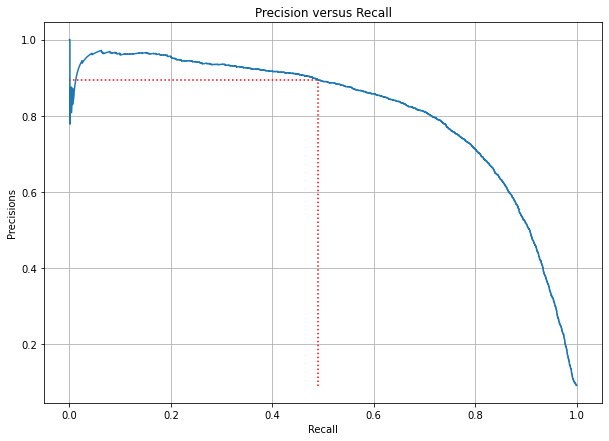

In [148]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(10, 7))
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precisions')
    plt.title('Precision versus Recall')
    plt.vlines(recalls[57000], precisions.min(), precisions[57000], colors='r', linestyles='dotted')
    plt.hlines(precisions[57000], recalls.min(), recalls[57000], colors='r', linestyles='dotted')
    plt.grid()
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

**You can see that precision really starts to fall sharply around 75% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.**

Suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 3,500. To be more precise you can search for the lowest threshold that gives you at least 90% precision (`np.argmax()` will give you the first index of the maximum value, which in this case means the `first True value`):

In [166]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

In [167]:
threshold_90_precision

3370.0194991439557

To make predictions (on the training set for now), `instead of calling the classifier’s predict()` method, you can run this code:

In [168]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Let's check these `predictions' precision and recall`:

In [169]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [171]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, you have a `90% precision classifier`! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. <br>
But wait, not so fast. A high-precision classifier is not very useful if its recall is too low!

## TIP

> If someone says, "**`Let's reach 99% precision," you should ask, "At what recall?`**"

### The ROC Curve

* The `receiver operating characteristic (ROC) curve` is another common tool used with binary classifiers. 
* It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the `true positive rate (another name for recall)` against the `false positive rate (FPR)`. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 - (minus) the `true negative rate (TNR)`, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called `specificity`. Hence, **the ROC curve plots `sensitivity (recall)` versus 1 - (minus) specificity**.

To plot the ROC curve, you first use the `roc_curve()` function to compute the `TPR and FPR` for various threshold values:

In [23]:
from sklearn.metrics import roc_curve

In [173]:
roc_curve??

Signature:
roc_curve(
    y_true,
    y_score,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=True,
)
Source:   
@_deprecate_positional_args
def roc_curve(y_true, y_score, *, pos_label=None, sample_weight=None,
              drop_intermediate=True):
    """Compute Receiver operating characteristic (ROC)

    Note: this implementation is restricted to the binary classification task.

    Read more in the :ref:`User Guide <roc_metrics>`.

    Parameters
    ----------

    y_true : array, shape = [n_samples]
        True binary labels. If labels are not either {-1, 1} or {0, 1}, then
        pos_label should be explicitly given.

    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive
        class, confidence values, or non-thresholded measure of decisions
        (as returned by "decision_function" on some classifiers).

    pos_label : int or str, default=None
        The label of the positive class.

In [36]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
# fpr, tpr, thresholds = roc_curve(y_train_5, y_scores, drop_intermediate=False)

In [186]:
type(fpr), type(tpr), type(thresholds)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [187]:
fpr.shape, tpr.shape, thresholds.shape

((3908,), (3908,), (3908,))

In [188]:
ind = 340
fpr[ind], tpr[ind], thresholds[ind]

(0.003444548269480936, 0.3879358052019923, 5344.335016926949)

Then you can plot the FPR against the TPR using Matplotlib. This code produces the plot in below Figure (plot):

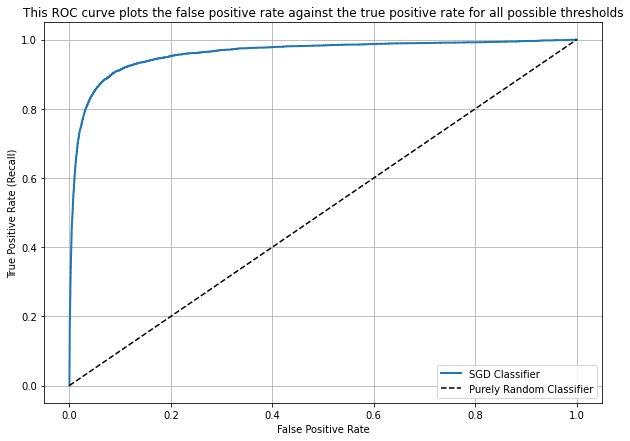

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='Purely Random Classifier') # Dashed diagonal
    plt.grid()
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('This ROC curve plots the false positive rate against the true positive rate for all possible thresholds')

plot_roc_curve(fpr, tpr, label='SGD Classifier')
plt.show()

In above Figure/Plot: <br>
Once again there is a trade-off: `the higher the recall (TPR), the more false positives (FPR)` the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

* `One way to compare classifiers is to measure the area under the curve (AUC)`. 
* A perfect classifier will have a `ROC AUC` equal to 1, whereas a purely random classifier will have a `ROC AUC` equal to 0.5. <br>

Scikit-Learn provides a function to compute the `ROC AUC`:

In [24]:
from sklearn.metrics import roc_auc_score

In [194]:
roc_auc_score??

Signature:
roc_auc_score(
    y_true,
    y_score,
    *,
    average='macro',
    sample_weight=None,
    max_fpr=None,
    multi_class='raise',
    labels=None,
)
Source:   
@_deprecate_positional_args
def roc_auc_score(y_true, y_score, *, average="macro", sample_weight=None,
                  max_fpr=None, multi_class="raise", labels=None):
    """Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    from prediction scores.

    Note: this implementation can be used with binary, multiclass and
    multilabel classification, but some restrictions apply (see Parameters).

    Read more in the :ref:`User Guide <roc_metrics>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_classes)
        True labels or binary label indicators. The binary and multiclass cases
        expect labels with shape (n_samples,) while the multilabel case expects
        binary label indicators with shape (n_samples, n_classes).

    y_score 

In [195]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## **`TIP`**

> Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder **`how to decide which one to use`**. <br>
> As a rule of thumb, you should **`prefer the PR curve`** whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, **`use the ROC curve`**. <br>
> **For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).**

#### **Let’s now train a `RandomForestClassifier` and compare its ROC curve and ROC AUC score to those of the SGDClassifier.** 
- First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), `the RandomForestClassifier class does not have a decision_function() method`. Instead, it has a **`predict_proba()`** method. <br>
- Scikit-Learn classifiers generally have one or the other, or both. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [30]:
y_probas_forest.shape, type(y_probas_forest)

((60000, 2), numpy.ndarray)

The `roc_curve()` function expects labels and scores, but instead of scores you can give it class probabilities. Let’s use the positive class’s probability as the score:

In [31]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

In [32]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [33]:
type(fpr_forest), type(tpr_forest), type(thresholds_forest)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [34]:
fpr_forest.shape, tpr_forest.shape, thresholds_forest.shape

((101,), (101,), (101,))

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare in below Figure (plot):

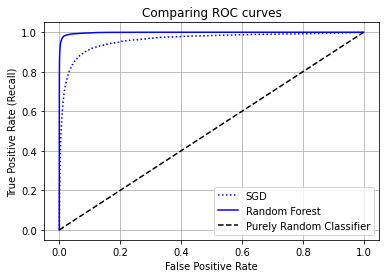

In [42]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plt.plot(fpr_forest, tpr_forest, 'b-', label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Purely Random Classifier') # Dashed diagonal
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title("Comparing ROC curves")
plt.legend(loc='lower right')
plt.show()

As you can see in above Figure (plot), the `RandomForestClassifier’s` ROC curve looks much better than the `SGDClassifier’s`: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better:

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Try measuring the precision and recall scores: you should find **99.0% precision and 86.6% recall**. Not too bad!

In [45]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [46]:
precision_score(y_train_5, y_pred_forest)

0.9905083315756169

In [47]:
recall_score(y_train_5, y_pred_forest)

0.8662608374838591

* You now know how to `train binary classifiers`, 
* `choose the appropriate metric for your task`, 
* `evaluate your classifiers using cross-validation`, 
* `select the precision/recall trade-off that fits your needs`,
* and `use ROC curves and ROC AUC scores to compare various models`. 

**Now let’s try to detect more than just the 5s.**

## **Multiclass Classification**

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can `distinguish between more than two classes`.

Some algorithms (such as `SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers`.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the **`one-versus-the-rest (OvR) strategy (also called one-versus-all).`**

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called **`the one-versus-one (OvO) strategy`**. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. `The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.`

Some algorithms (such as **`Support Vector Machine classifiers) scale poorly with the size of the training set`**. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. _For most binary classification algorithms, however, **OvR is preferred**_.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier (see Chapter 5), using the sklearn.svm.SVC class:

In [26]:
from sklearn.svm import SVC

In [49]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [58]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

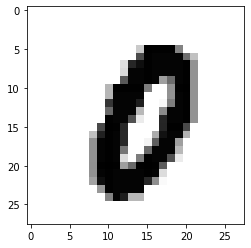

In [63]:
plt.imshow(X_train[34].reshape((28, 28)), cmap='binary')

In [59]:
svm_clf.predict([X_train[34]])

array([0], dtype=uint8)

That was easy! This code trains the *SVC* on the training set using the original target classes from 0 to 9 (*y_train*), instead of the 5-versus-the-rest target classes (*y_train_5*). Then it makes a prediction (a correct one in this case). **`Under the hood, Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.`**

If you call the `decision_function()` method, you will see that it returns 10 scores per instance (instead of just 1). _That’s one score per class_:

In [51]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

The highest score is indeed the one corresponding to class 5

In [52]:
np.argmax(some_digit_score)

5

In [56]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [57]:
svm_clf.classes_[5]

5

## WARNING

> When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky.

If you want to force Scikit-Learn to use `one-versus-one or one-versus-the-rest`, you can use the `OneVsOneClassifier or OneVsRestClassifier` classes. <br>
Simply create an instance and pass a classifier to its constructor (it does not even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [27]:
from sklearn.multiclass import OneVsRestClassifier

In [67]:
ovr_clf = OneVsRestClassifier(SVC(), n_jobs=3)
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(), n_jobs=3)

In [68]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [69]:
ovr_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [70]:
ovr_clf.decision_function([some_digit])

array([[-2.20788779, -2.52734154, -1.42209483, -0.89545795, -3.66438164,
         1.09884347, -3.13930844, -2.05006487, -2.51601851, -3.39312853]])

Training an `SGDClassifier (or a RandomForestClassifier)` is just as easy:

In [65]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [104]:
ind = 3432
sgd_clf.predict([X_train[ind]])

array([8], dtype=uint8)

In [105]:
y_train[ind]

8

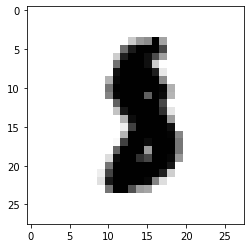

In [106]:
plt.imshow(X_train[ind].reshape(28, 28), cmap='binary')

**`This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can directly classify instances into multiple classes.`** <br>
The `decision_function()` method now _returns one value per class_. <br>
Let’s look at the score that the SGD classifier assigned to each class:

In [107]:
sgd_clf.decision_function([X_train[ind]])

array([[-57669.91757215,  -8225.62227232,  -9129.41709043,
          -936.17289826, -15728.31444993,  -9964.60972154,
        -12097.58059589, -19372.0120942 ,   -313.81096093,
        -10604.83895584]])

In [108]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

You can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 8 has a score of -313.8. The model has a slight doubt regarding class 3, which gets a score of -936.2. <br>
Now of course you want to `evaluate this classifier`. As usual, you can use cross-validation. Use the `cross_val_score()` function to evaluate the `SGDClassifier’s accuracy`:

In [74]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It gets `over 85%` on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy `above 89%`:

In [28]:
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [75]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

**`If this were a real project, you would now follow the steps in your Machine Learning project checklist (see Appendix B). You’d explore data preparation options, try out multiple models (shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV), and automate as much as possible.`** <br>
Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First, look at the confusion matrix. You need to make predictions using the `cross_val_predict()` function, then call the `confusion_matrix()` function, just like you did earlier:

In [29]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [30]:
type(y_train_pred), y_train_pred.shape

(numpy.ndarray, (60000,))

In [31]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [120]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

That’s a lot of numbers. It’s often more convenient to look at an `image representation of the confusion matrix`, using Matplotlib’s `matshow()` function:

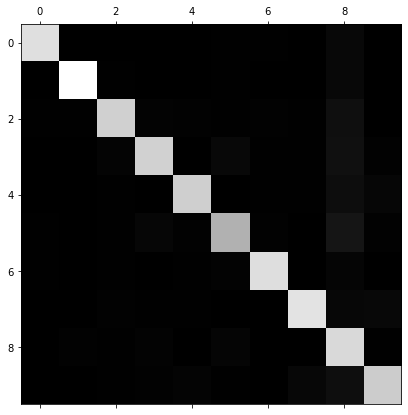

In [40]:
plt.figure(figsize=(20, 7))
plt.matshow(conf_mx, 0, cmap=plt.cm.gray) 

This confusion matrix looks pretty good, since most images are on the main diagonal, which means that they were classified correctly. <br>
**The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits. In fact, you can verify that both are the case.**

Let’s focus the `plot on the errors`. 
* First, you need to divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute numbers of errors (which would make abundant classes look unfairly bad):

In [59]:
row_sums = conf_mx.sum(axis=1, keepdims=True)

In [60]:
print(row_sums)

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]


In [61]:
norm_conf_mx = conf_mx/row_sums

Fill the diagonal with zeros to keep only the errors, and plot the result:

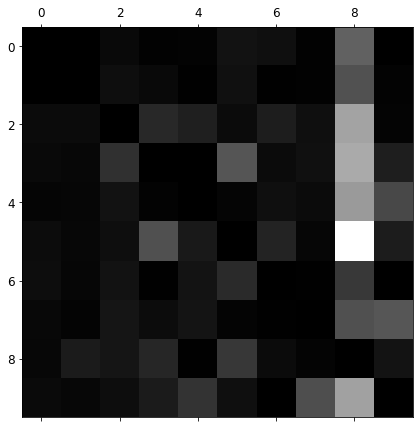

In [62]:
np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(10, 7))
plt.matshow(norm_conf_mx, 1, cmap=plt.cm.gray)
plt.show()

You can clearly see the kinds of errors the classifier makes. _Remember that rows represent actual classes, while columns represent predicted classes._ <br>
The column for **_class 8_** is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions).

`Analyzing the confusion matrix often gives you insights into ways to improve your classifier.` <br>
* **Looking at this plot, it seems that your efforts should be spent on reducing the false 8s.** 
* **For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s.** 
* **Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none).** 
* **Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more.**

> **Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming**. <br>
> For example, let’s plot examples of 3s and 5s (the `plot_digits()` function just uses Matplotlib’s `imshow()` function; see this chapter’s Jupyter notebook for details):

In [63]:
cl_a, cl_b = 3, 5

In [76]:
X_aa = X_train[(y_train.astype('int') == cl_a) & (y_train_pred.astype('int') == cl_a)]
X_ab = X_train[(y_train.astype('int') == cl_a) & (y_train_pred.astype('int') == cl_b)]
X_ba = X_train[(y_train.astype('int') == cl_b) & (y_train_pred.astype('int') == cl_a)]
X_bb = X_train[(y_train.astype('int') == cl_b) & (y_train_pred.astype('int') == cl_b)]

# print((y_train.astype('int') == cl_a) & (y_train_pred.astype('int') == cl_a))

In [77]:
X_aa.shape, X_ab.shape, X_ba.shape, X_bb.shape

((5227, 784), (203, 784), (168, 784), (4444, 784))

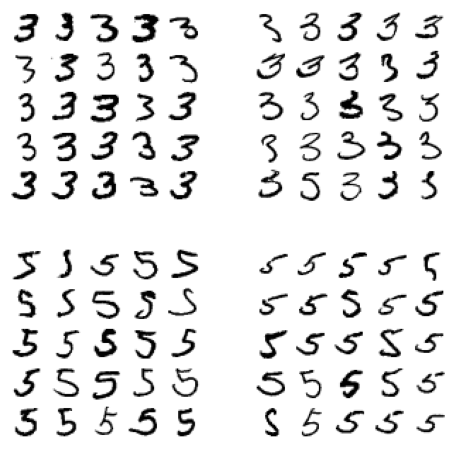

In [79]:
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5 blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e., in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 in the first row and second column truly looks like a badly written 3). <br>
**However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did.** <br>
**`The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.`**

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. 
**`In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.`**

### Multilabel Classification

Until now each instance has always been assigned to just one class. <br>
In some cases you may want your classifier to output multiple classes for each instance. <br>
Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture? It should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). **Such a classification system that outputs multiple binary tags is called a `multilabel classification system`.**

We won’t go into face recognition just yet, but let’s look at a simpler example, just for illustration purposes:

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
y_train_large = (y_train.astype('int') >= 7)

In [19]:
y_train_large.shape

(60000,)

In [20]:
y_train_odd = (y_train.astype('int') % 2 == 1)

In [21]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [86]:
KNeighborsClassifier??

Init signature:
KNeighborsClassifier(
    n_neighbors=5,
    *,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None,
    **kwargs,
)
Source:        
class KNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                           SupervisedIntegerMixin, ClassifierMixin):
    """Classifier implementing the k-nearest neighbors vote.

    Read more in the :ref:`User Guide <classification>`.

    Parameters
    ----------
    n_neighbors : int, default=5
        Number of neighbors to use by default for :meth:`kneighbors` queries.

    weights : {'uniform', 'distance'} or callable, default='uniform'
        weight function used in prediction.  Possible values:

        - 'uniform' : uniform weights.  All points in each neighborhood
          are weighted equally.
        - 'distance' : weight points by the inverse of their distance.
          in this case, closer neighbors of a query point will have a


In [22]:
knn_clf = KNeighborsClassifier()

In [88]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a *y_multilabel* array containing two target labels for each digit image: <br>
- the first indicates whether or not the digit is large (7, 8, or 9), and 
- the second indicates whether or not it is odd. 

The next lines create a KNeighborsClassifier instance (which supports multilabel classification, though not all classifiers do), and we train it using the multiple targets array. Now you can make a prediction, and notice that it outputs two labels:

In [89]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large (False) and odd (True).

There are many ways to `evaluate a multilabel classifier`, and `selecting the right metric` really depends on your project. 
- One approach is to measure the $F_1$ score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. This code computes the average $F_1$ score across all labels:

In [23]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [24]:
type(y_multilabel), type(y_train_knn_pred)

(numpy.ndarray, numpy.ndarray)

In [25]:
y_multilabel.shape, y_train_knn_pred.shape

((60000, 2), (60000, 2))

In [30]:
f1_score(y_multilabel[:, 0], y_train_knn_pred[:, 0])

0.970845724132181

In [29]:
f1_score(y_multilabel[:, 1], y_train_knn_pred[:, 1])

0.981974806989029

In [33]:
# taking the average of above two f1_scores and getting below cell score
(f1_score(y_multilabel[:, 0], y_train_knn_pred[:, 0]) + f1_score(y_multilabel[:, 1], y_train_knn_pred[:, 1])) / 2

0.976410265560605

In [26]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

This assumes that all labels are equally important, however, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the preceding code

In [31]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

### Multioutput Classification

The last type of classification task we are going to discuss here is called **`multioutput–multiclass classification`** (or `simply multioutput classification`). It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput classification system.

## NOTE

> The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification. Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels.

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities with NumPy’s randint() function. The target images will be the original images:

In [35]:
noise = np.random.randint(0, 100, (len(X_train), 784))

In [36]:
noise.shape

(60000, 784)

In [37]:
X_train.shape

(60000, 784)

In [38]:
X_train_mod = X_train + noise

In [39]:
X_train_mod.shape

(60000, 784)

In [40]:
noise = np.random.randint(0, 100, (len(X_test), 784))

In [41]:
noise.shape

(10000, 784)

In [42]:
X_test.shape

(10000, 784)

In [43]:
X_test_mod = X_test + noise

In [44]:
X_test_mod.shape

(10000, 784)

In [45]:
y_train_mod = X_train

In [46]:
y_test_mod = X_test

Let’s take a peek at an image from the test set (yes, we’re snooping on the test data, so you should be frowning right now):

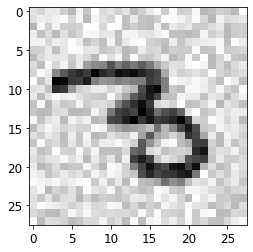

In [49]:
plt.imshow(X_train_mod[30].reshape(28, 28), cmap='binary')

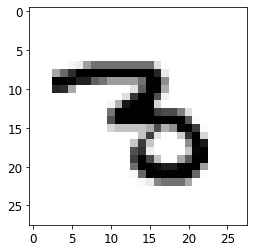

In [56]:
plt.imshow(y_train_mod[30].reshape(28, 28), cmap='binary')

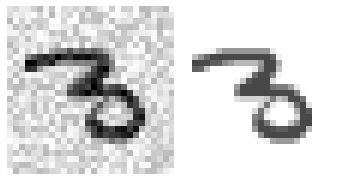

In [55]:
plot_digits([X_train_mod[30], y_train_mod[30]])

On the left is the noisy input image, and on the right is the clean target image. Now let’s train the classifier and make it clean this image:

In [51]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [52]:
clean_digit = knn_clf.predict([X_train_mod[30]])

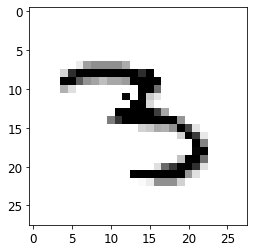

In [59]:
plt.imshow(clean_digit.reshape(28, 28), cmap='binary')

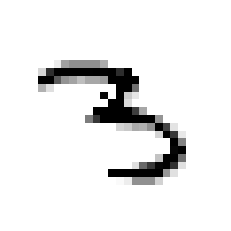

In [53]:
plot_digit(clean_digit)

Looks close enough to the target! This concludes our tour of classification. You should now know how to select good metrics for classification tasks, pick the appropriate precision/recall trade-off, compare classifiers, and more generally build good classification systems for a variety of tasks.